In [1]:
import pandas as pd
from pandas_datareader import data, wb
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats, integrate
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
import bs4 as bs
import requests
import yfinance as yf
import seaborn as sns

import cvxpy as cp

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

(CVXPY) Apr 28 11:11:28 AM: Encountered unexpected exception importing solver ECOS:
ImportError('numpy.core.multiarray failed to import')


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

(CVXPY) Apr 28 11:11:28 AM: Encountered unexpected exception importing solver ECOS_BB:
ImportError('numpy.core.multiarray failed to import')


In [2]:
import numpy as np

## Get Universe - Current S&P 500 stocks that exhisted in 2002

In [3]:
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

tickers = [s.replace('\n', '') for s in tickers]
start = datetime(2000,1,1)
end = datetime(2022,1,1)
data = yf.download(tickers, start=start, end=end)

[*********************100%***********************]  504 of 504 completed

3 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- CEG: Data doesn't exist for startDate = 946702800, endDate = 1641013200
- BF.B: No data found for this date range, symbol may be delisted


In [4]:
SP_Close = data['Adj Close']
SP_Close=SP_Close.dropna(axis=0, how='all')
SP_Close=SP_Close.dropna(axis=1)

## Testing Initial Portfolio without Bayes

In [5]:
five_year_data=SP_Close[:1265] #5 years of data

In [6]:
from pypfopt.efficient_frontier import EfficientFrontier

mu = mean_historical_return(five_year_data)
S = CovarianceShrinkage(five_year_data).ledoit_wolf()
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
#ef.save_weights_to_file("weights.txt")  # saves to file
print(ef.portfolio_performance(verbose=True))
#print(cleaned_weights)

Expected annual return: 44.8%
Annual volatility: 13.6%
Sharpe Ratio: 3.15
(0.4481389940639212, 0.13591566909106206, 3.1500341125280604)


## Look at some correlations and clustering to gather ideas

/opt/homebrew/Caskroom/miniforge/base/envs/tfenv/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 864x576 with 0 Axes>

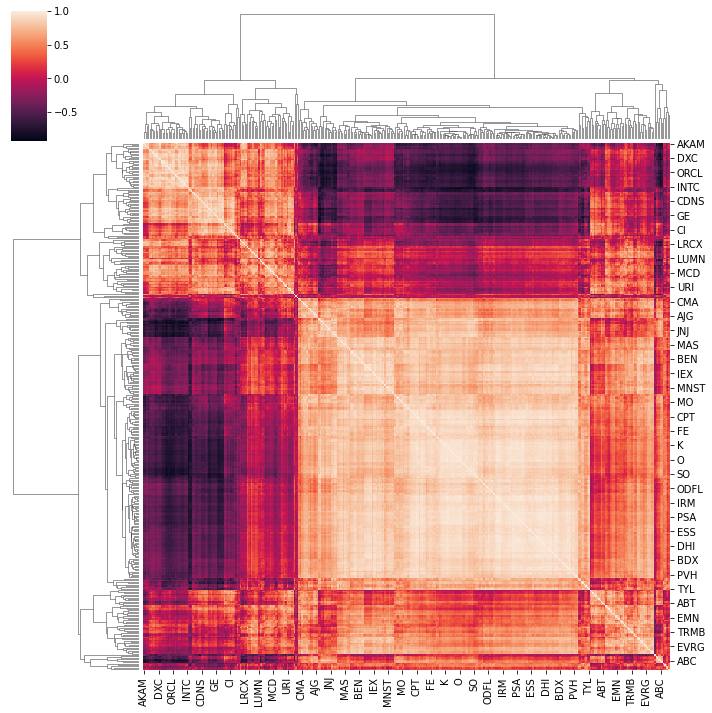

In [7]:
corr = five_year_data.corr()
plt.figure(figsize=(12,8))
sns.clustermap(corr)

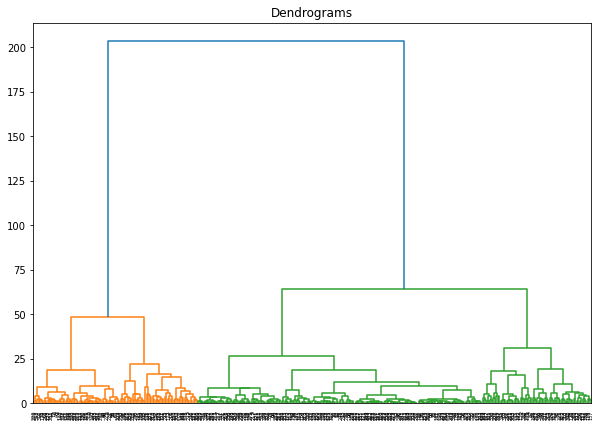

In [8]:
import scipy.cluster.hierarchy as shc
dimensions = SP_Close.shape[1]
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(corr, method='ward'))

In [12]:
from sklearn.cluster import AgglomerativeClustering

In [13]:
#rule is to select number of clusters clusters such that at most stock_pct_thresh of stocks are in clusters 
#with an internal corr of corr_thresh
corr_thresh = .7
stock_pct_thresh = .1

In [14]:
ix = -1
threshes = np.exp(np.arange(0,5,.05))#need a better system for this to make it not dependant on number of assets

for i in range(len(threshes)):
    thresh = threshes[ix]
    cluster = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward',distance_threshold=thresh)  
    kclusters = cluster.fit_predict(corr)
    stock_clusters=pd.DataFrame(SP_Close.columns.values).set_index(0)
    stock_clusters['cluster']=kclusters
    cluster_number = stock_clusters['cluster'].max()+1

    internal_corr_average = np.zeros([cluster_number])
    for n in range(cluster_number):
        cluster_corr = corr.loc[stock_clusters.loc[stock_clusters['cluster']==n].index,stock_clusters.loc[stock_clusters['cluster']==n].index]
        internal_corr_average[n] = cluster_corr.mean().mean()
    clustersWInternalCorrLessThanThreshold = np.argwhere(internal_corr_average<corr_thresh).flatten()
    percent_stocks_in_bad_clusters = len(stock_clusters.loc[stock_clusters['cluster'].isin(clustersWInternalCorrLessThanThreshold)])/len(stock_clusters)
    if percent_stocks_in_bad_clusters > stock_pct_thresh:
        ix-=1
    else:
        break
print(cluster_number)
print(percent_stocks_in_bad_clusters)

45
0.08174386920980926


In [ ]:
stock_clusters

In [ ]:
for i, thresh in enumerate(threshes):
    cluster = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward',distance_threshold=thresh)  
    kclusters = cluster.fit_predict(corr)
    stock_clusters=pd.DataFrame(SP_Close.columns.values)
    stock_clusters=stock_clusters.set_index(0)
    stock_clusters['cluster']=kclusters
    cluster_number = stock_clusters['cluster'].max()+1

    internal_corr_average = np.zeros([cluster_number])
    for n in range(cluster_number):
        cluster_corr = corr.loc[stock_clusters.loc[stock_clusters['cluster']==n].index,stock_clusters.loc[stock_clusters['cluster']==n].index]
        internal_corr_average[n] = cluster_corr.mean().mean()
    

In [ ]:
num_of_clusters

In [ ]:
temp = plt.hist(internal_corr_average,bins=15)
plt.title("hist of ave of internal correlation matrices")
plt.show()

In [ ]:
plt.hist(stock_clusters,bins=stock_clusters['cluster'].max())

In [ ]:
def calculate_posterior_mean(like_pop, prior_pop):
    mu0 = prior_pop.mean()
    w0 = prior_pop.std()
    dbar = like_pop.mean()
    w = like_pop.std()
    # Prior:
    prior = stats.norm(mu0, w0)
    # Likelihood:
    like = stats.norm(dbar, w)
    #computer posterior mean, std, distribution
    B = w**2/(w**2+w0**2)
    mu_s =dbar+B*(mu0-dbar)
    w_s = w*np.sqrt(1-B)
    posterior = stats.norm(mu_s, w_s)
    return mu_s

#calculated expected return array
def likelihood_n_posterior_mus(n, data, period=16): #period of 16 is 3 months with weekly data
    like_mus = np.zeros(len(data.columns))
    post_mus = np.zeros(len(data.columns))
    for ints,sector in enumerate(data
                                 .columns): 
        likelihood_pop = np.array(data.iloc[n-period : n - 1][sector])
        prior_pop = np.array(data.iloc[n-period : n - 1])
        like_mus[ints] = likelihood_pop.mean() #normal mean opt 
        post_mus[ints] = calculate_posterior_mean(likelihood_pop,prior_pop) #bayesian means 
    return like_mus, post_mus

## Markowitz Rebalancer

In [ ]:
def Markowits_Bayes_Rebalance(securities_vector, rebalance_period,prior_period,update_period=0,verbose=True,weight_bounds=(-1,1)):
    #Bayesian update not yet implemented
    i=1
    i_ =round((len(securities_vector)-prior_period)/rebalance_period)
    weights_list=[]
    dates=[]
    for p in range(0,len(securities_vector)-prior_period,rebalance_period):
        
        prior_vector = securities_vector[p:prior_period+p]
        
        if verbose:
            print("Iteration " + str(i) + " of " + str(i_))
            print(str(prior_vector.index[0]) + " - " + str(prior_vector.index[-1]))
            
            
        mu = mean_historical_return(prior_vector)
        S = CovarianceShrinkage(prior_vector).ledoit_wolf()
        ef = EfficientFrontier(mu, S,weight_bounds=weight_bounds)
        weights = ef.max_sharpe()
        cleaned_weights = ef.clean_weights()
        weights_list.append(cleaned_weights)
        dates.append(prior_vector.index[-1])
        i+=1
    weight_df=pd.DataFrame(weights_list)
    weight_df.index=dates

    return weight_df

In [ ]:
monthly_vanilla_markowitz = Markowits_Bayes_Rebalance(SP_Close,21,252*5,verbose=False) #monthly rebalance with 5 year matrix

In [ ]:
monthly_vanilla_markowitz